## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score, make_scorer

# we use balanced accuracy as score 
# http://mvpa.blogspot.com/2015/12/balanced-accuracy-what-and-why.html

balanced_accuracy = make_scorer(balanced_accuracy_score)



import seaborn as sb
%matplotlib inline

from scipy import stats

import seaborn as sns
sns.set(style="whitegrid")

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


## Univariate analysis 

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


There are no missing values.

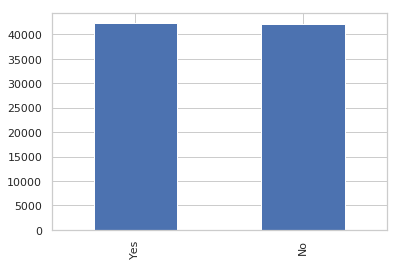

In [3]:
train_data["Promotion"].value_counts().plot.bar()

People who assigned the promotion is approximately equal to the people who receive the promotion. The ration between "Yes" and "No" values in the Promotion variable is an invariant metric. 

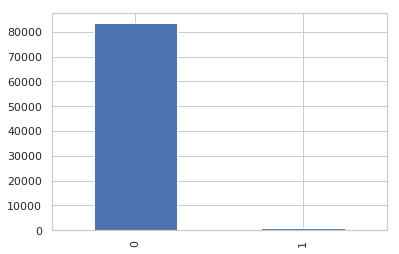

In [4]:
train_data["purchase"].value_counts().plot.bar()

In [5]:
train_data["purchase"].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

There only 1040 persons who purchased the product it represents the 1.23% of the data.

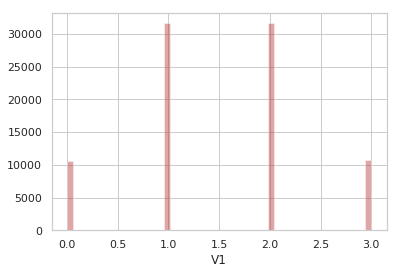

In [6]:
sns.distplot(train_data["V1"], kde=False, color="firebrick")

In [7]:
train_data["V1"].value_counts()

1    31631
2    31608
3    10670
0    10625
Name: V1, dtype: int64

The variable V1 has only 4 different values, we assume that this variable is discrete.

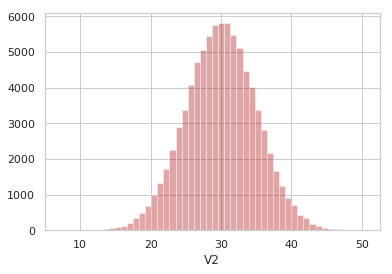

In [8]:
sns.distplot(train_data["V2"], kde=False, color="firebrick")

It seems that V2 variable shows a symmetric pattern but it is not a normal distribution according to the p-value of the kolmogov-smirnov test provided below.

In [9]:
stats.kstest(train_data["V2"], 'norm')[1]

0.0

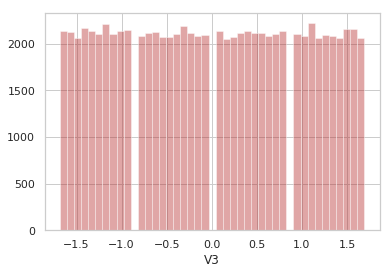

In [10]:
sns.distplot(train_data["V3"], kde=False, color="firebrick")

The V3 variable shows a uniform pattern. 

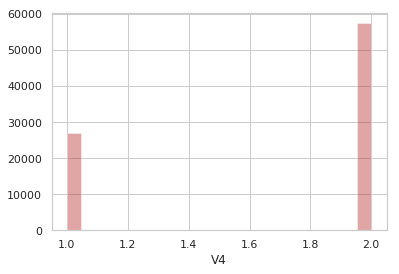

In [11]:
sns.distplot(train_data["V4"], kde=False, color="firebrick")

In [12]:
train_data["V4"].value_counts()

2    57450
1    27084
Name: V4, dtype: int64

The variable V4 has only 2 different values.

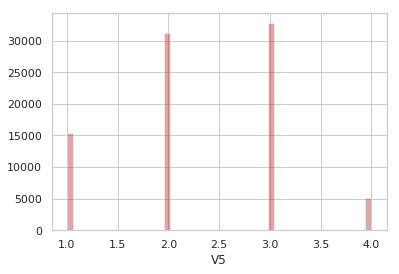

In [13]:
sns.distplot(train_data["V5"], kde=False, color="firebrick")

In [14]:
train_data["V5"].value_counts()

3    32743
2    31196
1    15412
4     5183
Name: V5, dtype: int64

The variable V5 has only 4 different values. 

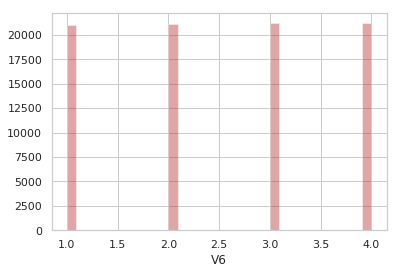

In [15]:
sns.distplot(train_data["V6"], kde=False, color="firebrick")

In [16]:
train_data["V6"].value_counts()

3    21186
4    21176
2    21146
1    21026
Name: V6, dtype: int64

The V6 variable has only 4 different values and it is uniformly distributed.

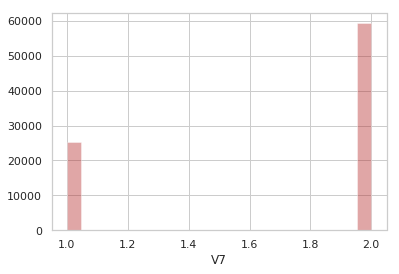

In [17]:
sns.distplot(train_data["V7"], kde=False, color="firebrick")

In [18]:
train_data["V7"].value_counts()

2    59317
1    25217
Name: V7, dtype: int64

The V7 variable has only 2 values. 

From the above, we decide to treat the following variables as categorical variables: V1, V4, V5, V6, V7, Promotion, and purchase.

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [20]:
variables_to_categrical = ['V1', 'V4', 'V5', 'V6', 'V7', 'Promotion', 'purchase']

for s in variables_to_categrical:
    train_data[s] = train_data[s].astype('category')

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null category
purchase     84534 non-null category
V1           84534 non-null category
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null category
V5           84534 non-null category
V6           84534 non-null category
V7           84534 non-null category
dtypes: category(7), float64(2), int64(1)
memory usage: 2.5 MB


We will generate bivariate analysis for clients with promotion and without promotion  in order to show differences among these groups.

In [22]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [23]:
index_promotion = train_data["Promotion"] == "Yes"
index_no_promotion = train_data["Promotion"] == "No"

In [24]:
train_data_with_promo = train_data[index_promotion]
train_data_without_promo = train_data[index_no_promotion]

## Bivariate analysis for clients with promotion

We will analyze the association between the purchase variable and the variables V1 - V7. We define the following functions in order to draw some insights. 

In [25]:
def stacked_bar(df, var1, var2):

    '''
    INPUT 
    df - a dataframe with all the columns: Promotion, purchase, V1 - V7 
    var1 - a categorical variable 
    var2 - a categorical variable 
    

    OUTPUT
    A stacked graph.                    
    '''        
    
    cross_tab = pd.crosstab(df[var1], df[var2])    
    ind = list(cross_tab.columns)
    stack_bar1 = list(cross_tab.iloc[0, ])
    stack_bar2 = list(cross_tab.iloc[1, ])
    p1 = plt.bar(ind, stack_bar1)
    p2 = plt.bar(ind, stack_bar2, bottom=stack_bar1)    

In [26]:
def chi_square_test(df, var1, var2):
    
    '''
    INPUT 
    df - a dataframe with all the columns: Promotion, purchase, V1 - V7 
    var1 - a categorical variable 
    var2 - a categorical variable 
    

    OUTPUT
    The chi-square test p-value
    '''        
        
    cross_tab = pd.crosstab(df[var1], df[var2])    
    
    
    return stats.chi2_contingency(cross_tab)[1]

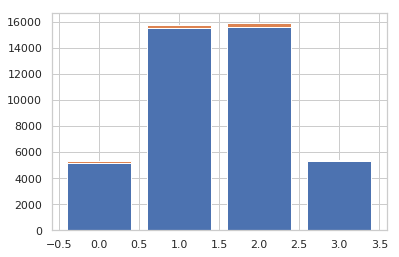

In [27]:
stacked_bar(train_data_with_promo, "purchase", "V1")

In [28]:
chi_square_test(train_data_with_promo, "purchase", "V1")

0.010528147663570743

With a significance level of 0.5 we reject the null hypothesis that there is no association between purchase and V1. 

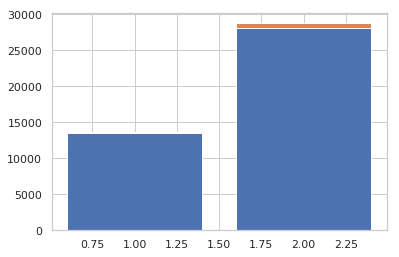

In [29]:
stacked_bar(train_data_with_promo, "purchase", "V4")

In [30]:
chi_square_test(train_data_with_promo, "purchase", "V4")

7.4104331231722175e-28

With a significance level of 0.5 we reject the null hypothesis that there is no association between purchase and V4. 

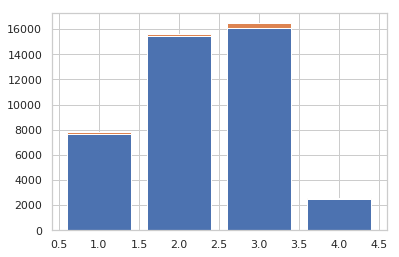

In [31]:
stacked_bar(train_data_with_promo, "purchase", "V5")

In [32]:
chi_square_test(train_data_with_promo, "purchase", "V5")

3.0428231330776582e-15

With a significance level of 0.5 we reject the null hypothesis that there is no association between purchase and V5. 

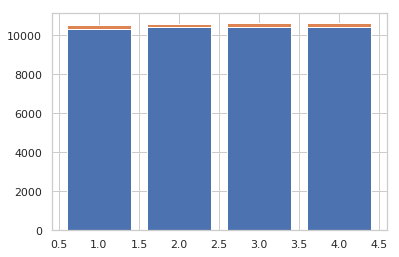

In [33]:
stacked_bar(train_data_with_promo, "purchase", "V6")

In [34]:
chi_square_test(train_data_with_promo, "purchase", "V6")

0.6354492873833075

With a significance level of 0.5 we cannot reject the null hypothesis that there is no association between purchase and V6. 

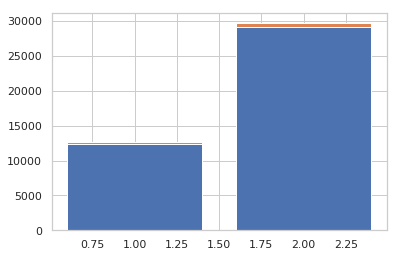

In [35]:
stacked_bar(train_data_with_promo, "purchase", "V7")

In [36]:
chi_square_test(train_data_with_promo, "purchase", "V7")

0.322562565660597

With a significance level of 0.5 we cannot reject the null hypothesis that there is no association between purchase and V7. Below, we show the association between the purchase and the quantitative variables: V2 and V3.

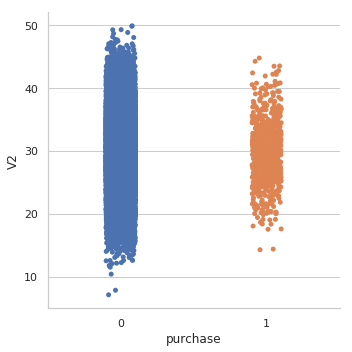

In [37]:
sns.catplot(x="purchase", y="V2", data=train_data_with_promo)

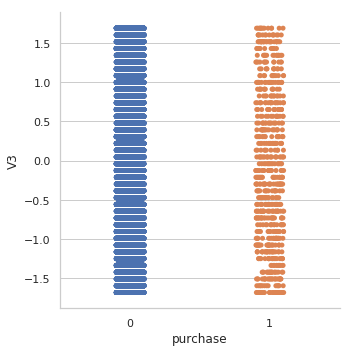

In [38]:
sns.catplot(x="purchase", y="V3", data=train_data_with_promo)

From the graphs above we see that there is some association between purchase and V2, on the other hand there is no association between purchase and V3. 

## Bivariate analysis for clients with no promotion

We will analyze the association between the purchase variable and the variables V1 - V7. We repeat the previously analysis.

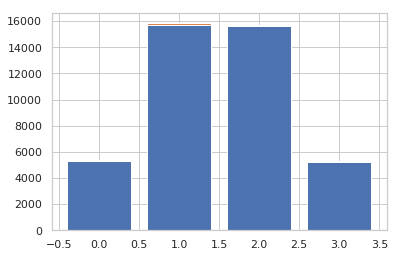

In [39]:
stacked_bar(train_data_without_promo, "purchase", "V1")

In [40]:
chi_square_test(train_data_without_promo, "purchase", "V1")

0.17147793471448397

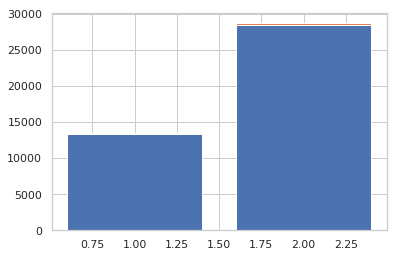

In [41]:
stacked_bar(train_data_without_promo, "purchase", "V4")

In [42]:
chi_square_test(train_data_without_promo, "purchase", "V4")

0.673731938407602

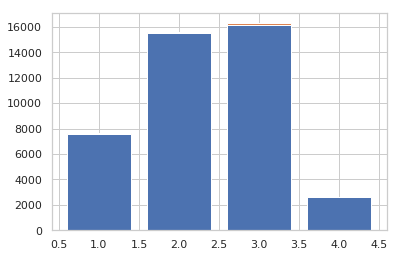

In [43]:
stacked_bar(train_data_without_promo, "purchase", "V5")

In [44]:
chi_square_test(train_data_without_promo, "purchase", "V5")

0.8824886356661493

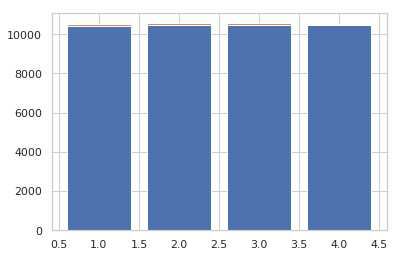

In [45]:
stacked_bar(train_data_without_promo, "purchase", "V6")

In [46]:
chi_square_test(train_data_without_promo, "purchase", "V6")

0.67937811472741

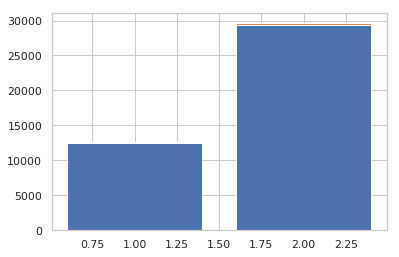

In [47]:
stacked_bar(train_data_without_promo, "purchase", "V7")

In [48]:
chi_square_test(train_data_without_promo, "purchase", "V7")

0.35687173345189704

With the data without promotion neither of the qualitative variables are associated with the purchase variable.

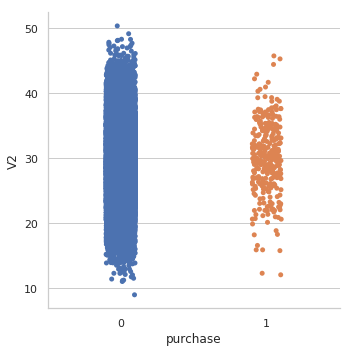

In [49]:
sns.catplot(x="purchase", y="V2", data=train_data_without_promo)

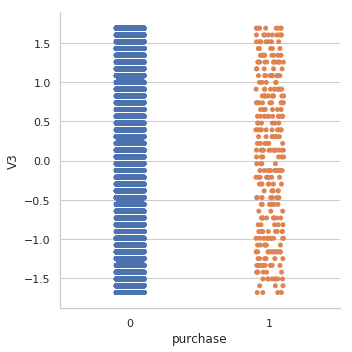

In [50]:
sns.catplot(x="purchase", y="V3", data=train_data_without_promo)

In the same way as the data with promotion there is some association between purchase and V2, on the other hand there is no association between purchase and V3. 

## Testing of Hypothesis 

We will test the following hypothesis: 

$ H_0: p1 = p2 $

$ H_1: p1 \neq p2 $

Where p1, p2 represents the proportion of purchases in the experimental and control group respectively. We will define the following function in order to test the above hypothesis. 


In [51]:
# good resource 
# https://stackoverflow.com/questions/53148935/one-sample-test-for-proportion
# http://www.statsmodels.org/0.6.1/generated/statsmodels.stats.proportion.proportions_ztest.html

def test_hypo(df):
    
    
    '''
    INPUT 
    df - a dataframe with all the columns: Promotion, purchase, V1 - V7 
    

    OUTPUT
    P-value in a two-sample z test for the difference of two proportions
    '''        
    
    
    df['purchase'] = df['purchase'].astype('int32')                
    purch_control = (df.groupby('Promotion')['purchase'].sum()).loc['No']
    purch_treat = df.groupby('Promotion')['purchase'].sum().loc['Yes']       
    cust_treat =  df["Promotion"].value_counts().loc['Yes']
    cust_control =  df["Promotion"].value_counts().loc['No']
    
    counts = np.array([purch_control, purch_treat])
    nobs = np.array([cust_control, cust_treat])
    
    stat, pval = proportions_ztest(counts, nobs, alternative='two-sided', prop_var=False)
    
    return pval

In [52]:
test_hypo(train_data)

1.1096419254071562e-35

The p-value is very small so we reject the null hypothesis that the two proportions are the same. Therefore the treatment (promotion) has a statistical significance on the response (purchase).

## Evaluation metrics 

In order to calculate the following evaluation metrics: 

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

We define the following functions. 

In [53]:
def iir(df):
    
    '''
    INPUT 
    df - a dataframe with all the columns: Promotion, purchase, V1 - V7 
    

    OUTPUT
    The evaluation metric IIR
    '''        
    
    
    df['purchase'] = df['purchase'].astype('int32')        
    purch_control = (df.groupby('Promotion')['purchase'].sum()).loc['No']
    purch_treat = df.groupby('Promotion')['purchase'].sum().loc['Yes']   
    cust_treat = df["Promotion"].value_counts().loc['Yes']
    cust_control = df["Promotion"].value_counts().loc['No']
    
    return (purch_treat/cust_treat) - (purch_control/cust_control)    

In [54]:
def nir(df):
    
    '''
    INPUT 
    df - a dataframe with all the columns: Promotion, purchase, V1 - V7 
    

    OUTPUT
    The evaluation metric NIR
    '''            
    
    df['purchase'] = df['purchase'].astype('int32')    
    purch_control = (df.groupby('Promotion')['purchase'].sum()).loc['No']
    purch_treat = (df.groupby('Promotion')['purchase'].sum()).loc['Yes']    
    cust_treat = df["Promotion"].value_counts().loc['Yes']
    
    
    return (10*purch_treat - 0.15*cust_treat) - (10*purch_control)

In [55]:
iir(train_data)

0.009454547819772702

In [56]:
nir(train_data)

-2334.5999999999995

So if we assign randomly the promotion, we will lose money and because of that we will use a random forest model in order to decide the person who will receive the promotion. 

## Random Forest 

In [57]:
X = train_data_with_promo.loc[:, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']].copy()
y = train_data_with_promo['purchase'].astype('int32')

In order to work with random forest we convert each categorical variable into numeric. 

In [58]:
for col in X.columns: 
    
    if str(X[col].dtypes) == 'category':
        X[col] = X[col].astype('int32')        

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [60]:
X_train = X_train.values 
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values 

In [61]:
# In order to treat with the imbalanced dataset classification problem, 
# we use the following resource:
# https://chrisalbon.com/machine_learning/trees_and_forests/handle_imbalanced_classes_in_random_forests/
# In addition we use a pipeline in order to avoid data leakage.

pipeline = Pipeline([('clf', RandomForestClassifier(random_state=0, 
                                                    n_jobs=-1, 
                                                    class_weight="balanced"))])

In [62]:
n_estimators =  [10, 50, 100, 200, 500]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [2, 3, 4,5,6,7,8, 10, 20, 50]
criterion = ['gini', 'entropy']
bootstrap = [True, False]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9 , 10]

In [63]:
parameters = {        
    'clf__n_estimators': n_estimators,
    'clf__max_features': max_features,
    'clf__max_depth': max_depth,
    'clf__criterion': criterion,    
    'clf__bootstrap': bootstrap, 
    'clf__min_samples_split': min_samples_split     
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=balanced_accuracy,  cv=3,   verbose=2, n_jobs=-1)

In [64]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 1378 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3201 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3970 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4821 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 5752 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 6765 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 7858 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 9033 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 10288 tasks      

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                

We will calculate the balanced accuracy in the test set in order to measure the performance of the model.

In [65]:
y_pred = cv.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.6347046297407986


We will test the model with the following function.

In [66]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    X = df.values
    y_pred = cv.predict(X)    
    promotion = np.where(y_pred == 1, "Yes", "No")
    
    return promotion

In [67]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 368.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01877400696360608, 368.25)

This approach improves the evaluation metrics significantly. It is possible that other approaches such as gradient boosting, neural networks, and support vector machines work better.